In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['happy','sarcasm', 'sad']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 73.4MB/s]


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Setup directory paths to train and test images
train_dir =  '/content/drive/MyDrive/dataset/train'
test_dir = '/content/drive/MyDrive/dataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
# Unzip the uploaded file
!unzip /content/going_modular.zip -d /content/


Archive:  /content/going_modular.zip
  inflating: /content/going_modular/engine.py  
  inflating: /content/going_modular/model_builder.py  
  inflating: /content/going_modular/predictions.py  
  inflating: /content/going_modular/train.py  
  inflating: /content/going_modular/utils.py  


In [ ]:
import sys

# Add the parent directory of the first going_modular folder to the Python path
sys.path.append('/content/going_modular')

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0714 | train_acc: 0.4197 | test_loss: 1.0160 | test_acc: 0.5180
Epoch: 2 | train_loss: 0.8735 | train_acc: 0.6391 | test_loss: 0.9708 | test_acc: 0.5036
Epoch: 3 | train_loss: 0.7680 | train_acc: 0.6706 | test_loss: 0.9380 | test_acc: 0.5276
Epoch: 4 | train_loss: 0.6821 | train_acc: 0.7254 | test_loss: 0.8769 | test_acc: 0.6046
Epoch: 5 | train_loss: 0.6215 | train_acc: 0.7874 | test_loss: 0.8614 | test_acc: 0.6046
Epoch: 6 | train_loss: 0.5727 | train_acc: 0.8039 | test_loss: 0.8980 | test_acc: 0.5276
Epoch: 7 | train_loss: 0.5288 | train_acc: 0.8198 | test_loss: 0.8775 | test_acc: 0.5661
Epoch: 8 | train_loss: 0.4936 | train_acc: 0.8548 | test_loss: 0.8675 | test_acc: 0.5661
Epoch: 9 | train_loss: 0.4618 | train_acc: 0.8741 | test_loss: 0.8870 | test_acc: 0.5661
Epoch: 10 | train_loss: 0.4333 | train_acc: 0.8785 | test_loss: 0.8843 | test_acc: 0.5661


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


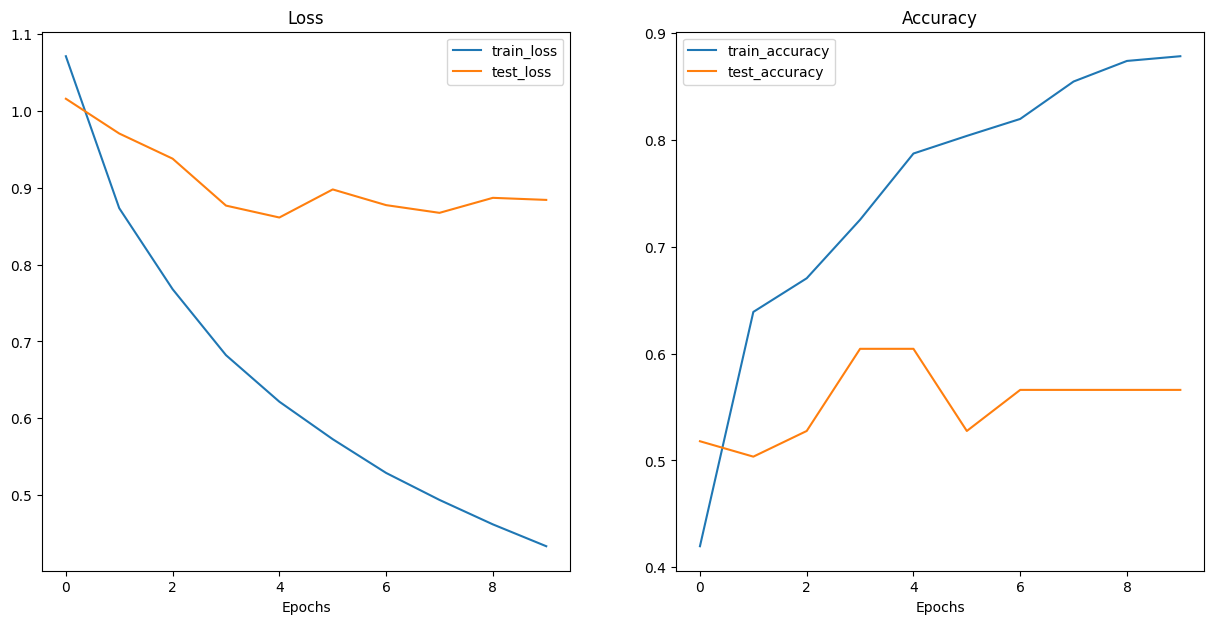

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

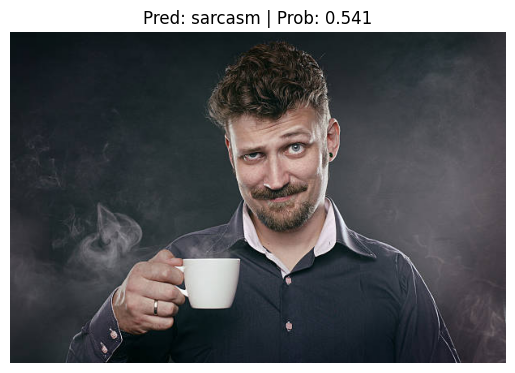

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

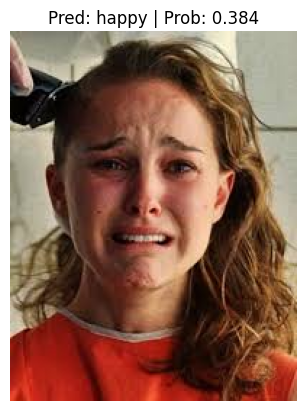

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_2.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

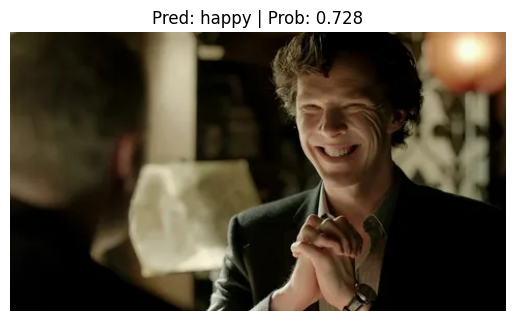

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_3.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

TypeError: cannot unpack non-iterable NoneType object

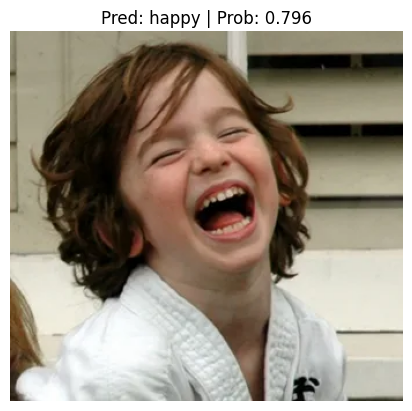

In [ ]:
import os
import numpy as np
import pandas as pd
from going_modular.predictions import pred_and_plot_image

# Define your test dataset path
test_dataset_path = '/content/drive/MyDrive/dataset/test'

# Initialize a list to store the results
results = []

# Dictionary to map folder names to class indices
class_names = ["happy", "sarcastic", "sad"]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Iterate through each class folder
for class_name in class_names:
    class_folder = os.path.join(test_dataset_path, class_name)
    for image_name in os.listdir(class_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(class_folder, image_name)

            # Predict the label for the image
            true_label = class_to_idx[class_name]
            prediction, probability = pred_and_plot_image(model=pretrained_vit,
                                                          image_path=image_path,
                                                          class_names=class_names)  # We set plot to False to avoid plotting

            # Append the result to the list
            results.append([image_name, class_name, prediction, probability[true_label]])

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=["Image", "True Label", "Predicted Label", "Probability"])

# Display the results table
print(results_df)

# Calculate the accuracy of the predictions
correct_predictions = results_df[results_df["True Label"] == results_df["Predicted Label"]].shape[0]
total_predictions = results_df.shape[0]
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2%}")


TypeError: cannot unpack non-iterable NoneType object

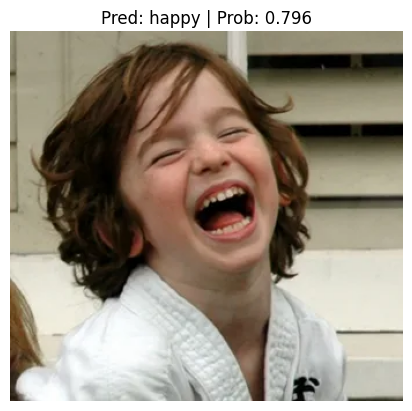

In [ ]:
import os
import torch
import pandas as pd
from typing import List
from torchvision import transforms
from PIL import Image
from going_modular.predictions import pred_and_plot_image  # Replace 'your_module' with the actual module name

# Initialize the model (assuming pretrained_vit is already defined and loaded with weights)
model = pretrained_vit

# Define your test dataset path
test_dataset_path = '/content/drive/MyDrive/dataset/test'

# Initialize a list to store the results
results = []

# Dictionary to map folder names to class indices
class_names = ["happy", "sarcastic", "sad"]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Iterate through each class folder
for class_name in class_names:
    class_folder = os.path.join(test_dataset_path, class_name)
    for image_name in os.listdir(class_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(class_folder, image_name)

            # Predict the label for the image
            true_label = class_to_idx[class_name]
            prediction, probability = pred_and_plot_image(model=model,
                                                          image_path=image_path,
                                                          class_names=class_names)

            # Append the result to the list
            results.append([image_name, class_name, prediction, probability])

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=["Image", "True Label", "Predicted Label", "Probability"])

# Display the results table
print(results_df)

# Calculate the accuracy of the predictions
correct_predictions = results_df[results_df["True Label"] == results_df["Predicted Label"]].shape[0]
total_predictions = results_df.shape[0]
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2%}")
